In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

## Dataset 준비
* 학습을 위해 제공되는 MNIST dataset을 준비

In [ ]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_data[10].shape

(28, 28)

In [ ]:
train_labels[11]

5

In [ ]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
set(train_labels[:100])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
# 데이터 전처리 파트 -> 도메인 지식이 들어가게 됩니다.
train_data = train_data / 255.
train_data = train_data.reshape(-1, 28 * 28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

In [ ]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### Dataset 구성
* 원활한 학습을 위해서 데이터셋을 구성해주고, Label을 one-hot으로 변환해준다.

In [ ]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [ ]:
batch_size = 64
max_epochs = 10

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)


# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [ ]:
# for train, label in train_dataset.take(3):
#     print(label)
# print("--------")
# for train, label in train_dataset.take(3):
#     print(label)

* 데이터 확인

label = 4


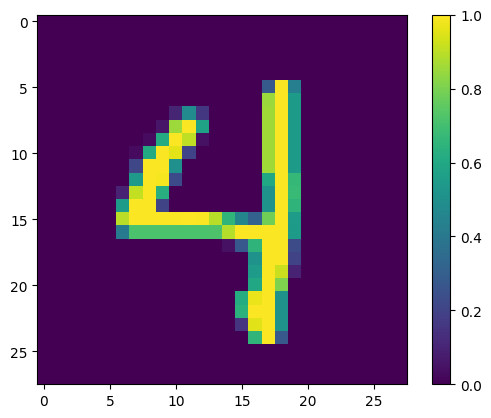

In [ ]:
index = 2190
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

# 모델 제작
## tf.keras.layers.Dense

```python
 def __init__(self,
               units,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
```

In [ ]:
# layers.Dense(64,
#              activation='relu',
#              kernel_initializer=tf.keras.initializers.HeNormal(),
#              kernel_regularizer=tf.keras.regularizers.L2(0.0001)
#              )

In [ ]:
# Flatten (inputs)
# Dense 128
# Dense 64
# Dense 32
# Dense 16
# (outputs)

# Models Sequential
model = tf.keras.models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10)
])



# Training
## tf.keras.losses.CategoricalCrossentropy()

```python
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
           [[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])
print('Loss: ', loss.numpy())  # Loss: 0.3239
```

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 확인

In [ ]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[ 0.12233416 -0.14552802 -0.09210555 -0.26191327  0.01325815  0.04612157
   0.21664068 -0.10428239 -0.0460753  -0.04098823]]


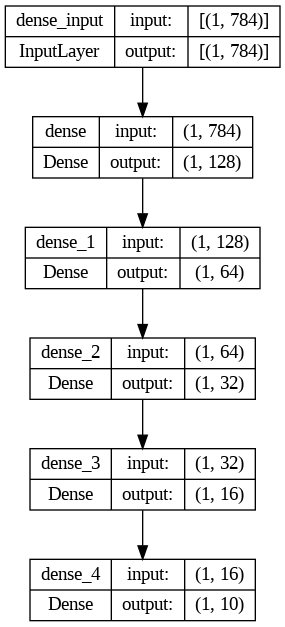

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 128)                  100480    
                                                                 
 dense_1 (Dense)             (1, 64)                   8256      
                                                                 
 dense_2 (Dense)             (1, 32)                   2080      
                                                                 
 dense_3 (Dense)             (1, 16)                   528       
                                                                 
 dense_4 (Dense)             (1, 10)                   170       
                                                                 
Total params: 111514 (435.60 KB)
Trainable params: 111514 (435.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습진행
* model.fit 함수가 최근에 model.fit_generator 함수와 통합
* Dataset을 이용한 학습을 진행

In [ ]:
# using `numpy type` data
# history = model.fit(train_data, train_labels,
#                     batch_size=batch_size, epochs=max_epochs,
#                     validation_split=0.05)
# using `tf.data.Dataset` # model.fit_generator
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size)

Epoch 1/10
937/937 [==============================] - 10s 5ms/step - loss: 1.0242 - accuracy: 0.6790
Epoch 2/10
937/937 [==============================] - 6s 6ms/step - loss: 0.3074 - accuracy: 0.9154
Epoch 3/10
937/937 [==============================] - 4s 5ms/step - loss: 0.2306 - accuracy: 0.9351
Epoch 4/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1934 - accuracy: 0.9442
Epoch 5/10
937/937 [==============================] - 6s 6ms/step - loss: 0.1679 - accuracy: 0.9516
Epoch 6/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1482 - accuracy: 0.9571
Epoch 7/10
937/937 [==============================] - 6s 7ms/step - loss: 0.1338 - accuracy: 0.9610
Epoch 8/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1217 - accuracy: 0.9652
Epoch 9/10
937/937 [==============================] - 5s 6ms/step - loss: 0.1102 - accuracy: 0.9681
Epoch 10/10
937/937 [==============================] - 6s 6ms/step - loss: 0.1017 - accuracy: 0.971

### 학습결과 확인

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

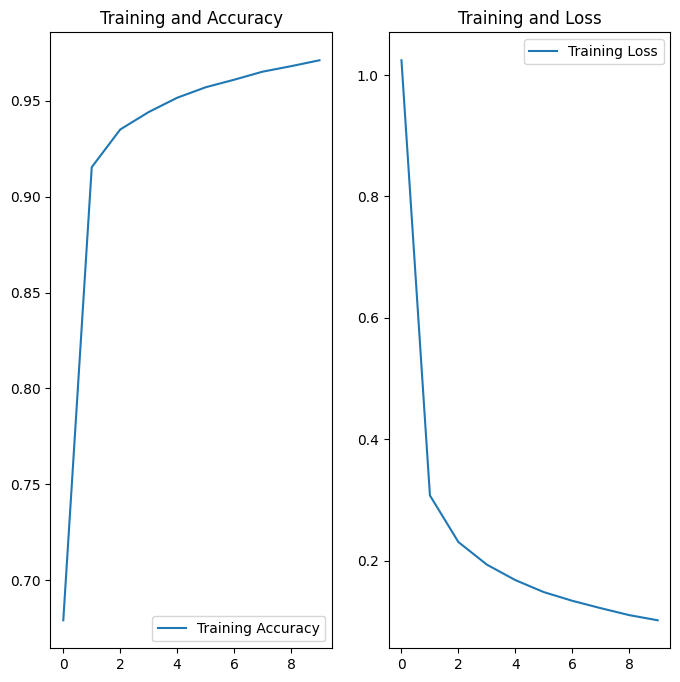

In [ ]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Loss')
plt.show()

In [ ]:
results = model.evaluate(test_dataset, steps=int(len(test_data) / batch_size))

156/156 [==============================] - 1s 3ms/step - loss: 0.1217 - accuracy: 0.9645


In [ ]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.122
accuracy value: 96.4543%


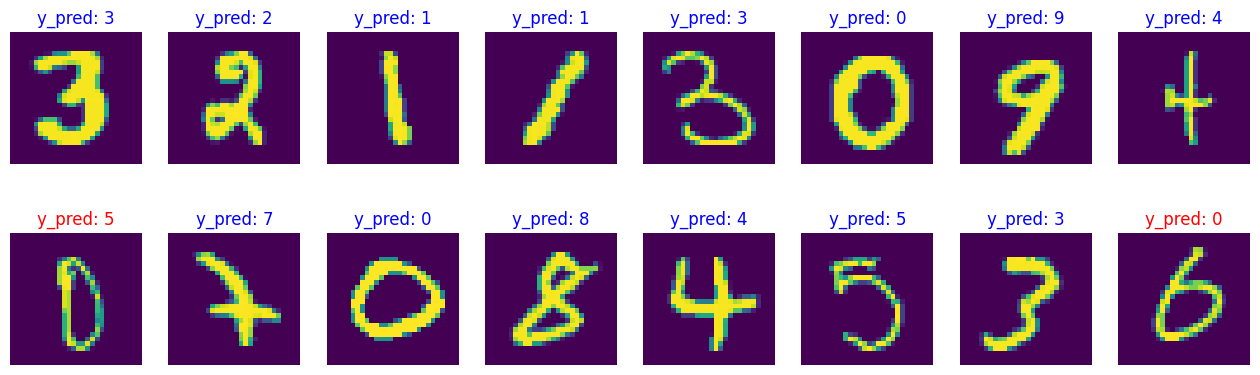

In [ ]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')